### [ 2026-01-23] 과제
#### NYC Taxi Dataset
① 요금(Fare Amount) 회귀 예측  	 => MAE
<!-- - ② 장거리 Trip 분류 			 => F1
- ③ 공항 Trip 여부 분류 			 => F1
- ④ Trip Duration(이동 시간) 회귀 예측 => MAE -->


[1] 모듈 로딩 <hr>

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.functional as F
import torchmetrics.functional as fn

In [2]:
## ==========================================
## 1. 데이터 로딩 및 메모리 관리
## ==========================================
import pandas as pd

path = "./data/yellow_tripdata_2015-01.csv"

usecols = [
    "VendorID",                     # 택시 회사 식별 ID (vendor 구분용)
    "tpep_pickup_datetime",         # 승객 픽업 시각 (시간 파생 피처 생성용)
    "tpep_dropoff_datetime",        # 승객 하차 시각 (운행 시간 계산용)
    "passenger_count",              # 탑승 인원 수
    "trip_distance",                # 이동 거리 (mile 단위, 요금에 가장 큰 영향)
    "pickup_longitude",             # 출발 지점 경도
    "pickup_latitude",              # 출발 지점 위도
    "dropoff_longitude",            # 도착 지점 경도
    "dropoff_latitude",             # 도착 지점 위도
    "RateCodeID",                   # 요금 체계 코드 (공항/고정요금 등)
    "store_and_fwd_flag",           # 저장 후 전송 여부 (Y/N, 통신 방식)
    "payment_type",                 # 결제 방식 (현금, 카드 등)
    "fare_amount",                  # 기본 요금 (예측 대상, target)
]



dtype = {
    "VendorID": "int8",
    "passenger_count": "int8",
    "RateCodeID": "int8",
    "payment_type": "int8",
    "trip_distance": "float32",
    "pickup_longitude": "float32",
    "pickup_latitude": "float32",
    "dropoff_longitude": "float32",
    "dropoff_latitude": "float32",
    "fare_amount": "float32",
    "store_and_fwd_flag": "category",
}

df = pd.read_csv(
    path,
    usecols=usecols,
    dtype=dtype,
    parse_dates=["tpep_pickup_datetime", "tpep_dropoff_datetime"],
    nrows=5_000_000,   # 일단 500만
)


df.info()





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 13 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int8          
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        int8          
 4   trip_distance          float32       
 5   pickup_longitude       float32       
 6   pickup_latitude        float32       
 7   RateCodeID             int8          
 8   store_and_fwd_flag     category      
 9   dropoff_longitude      float32       
 10  dropoff_latitude       float32       
 11  payment_type           int8          
 12  fare_amount            float32       
dtypes: category(1), datetime64[ns](2), float32(6), int8(4)
memory usage: 214.6 MB


In [3]:
# # ==========================================
# # [1-2] 다중 CSV 로딩 (전체 데이터 사용)
# # ==========================================
# import glob

# paths = sorted(glob.glob("./data/yellow_tripdata_*.csv"))
# print("사용 파일:", paths)

# usecols = [
#     "VendorID",                     # 택시 회사 식별 ID (vendor 구분용)
#     "tpep_pickup_datetime",         # 승객 픽업 시각 (시간 파생 피처 생성용)
#     "tpep_dropoff_datetime",        # 승객 하차 시각 (운행 시간 계산용)
#     "passenger_count",              # 탑승 인원 수
#     "trip_distance",                # 이동 거리 (mile 단위, 요금에 가장 큰 영향)
#     "pickup_longitude",             # 출발 지점 경도
#     "pickup_latitude",              # 출발 지점 위도
#     "dropoff_longitude",            # 도착 지점 경도
#     "dropoff_latitude",             # 도착 지점 위도
#     # "RateCodeID",                 # 요금 체계 코드 (공항/고정요금 등)
#     "store_and_fwd_flag",           # 저장 후 전송 여부 (Y/N, 통신 방식)
#     "payment_type",                 # 결제 방식 (현금, 카드 등)
#     "fare_amount",                  # 기본 요금 (예측 대상, target)
# ]



# dtype = {
#     "VendorID": "int8",
#     "passenger_count": "int8",
#     # "RateCodeID": "int8",
#     "payment_type": "int8",
#     "trip_distance": "float32",
#     "pickup_longitude": "float32",
#     "pickup_latitude": "float32",
#     "dropoff_longitude": "float32",
#     "dropoff_latitude": "float32",
#     "fare_amount": "float32",
#     "store_and_fwd_flag": "category",
# }

# dfs = []
# for p in paths:
#     print(f"loading: {p}")
#     df_part = pd.read_csv(
#         p,
#         usecols=usecols,
#         dtype=dtype,
#         parse_dates=["tpep_pickup_datetime", "tpep_dropoff_datetime"],
#         # nrows 옵션 제거 → 전체 사용
#     )
#     dfs.append(df_part)

# df = pd.concat(dfs, ignore_index=True)
# df.info()


In [4]:
## ==========================================
## 2. 컬럼 정리
## ==========================================

## ==========================================
## [2-1] datatime -> 숫자형으로 변환
## ==========================================

#- 타입확인
print(df["tpep_pickup_datetime"].dtype)
print(df["tpep_dropoff_datetime"].dtype)

#- 픽업시간 변환 0~23
df["pickup_hour"] = df["tpep_pickup_datetime"].dt.hour.astype("int8")

#- 요일 변환 0 = 월요일, 6 = 일요일
df["pickup_dayofweek"] = df["tpep_pickup_datetime"].dt.dayofweek.astype("int8")

#- 월 변환 
df["pickup_month"] = df["tpep_pickup_datetime"].dt.month.astype("int8")



## ==========================================
## [2-2] 컬럼 추가
## ==========================================
#- 운행시간 컬럼 
df["trip_duration"] = (
    (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"])
    .dt.total_seconds() / 60
)


#- 기존 행 제거
df.drop(
    columns=["tpep_pickup_datetime", "tpep_dropoff_datetime"],
    inplace=True
)

#- 이상치 바로 제거
df = df[(df["trip_duration"] > 0) & (df["trip_duration"] < 180)] ## 3시간 이상은 이상치로 간주


## ==========================================
## [2-3] 컬럼확인
## ==========================================
df[[
    "pickup_hour",
    "pickup_dayofweek",
    "pickup_month",
    "trip_duration"
]].describe()


datetime64[ns]
datetime64[ns]


,pickup_hour,pickup_dayofweek,pickup_month,trip_duration
count,4.990007e+06,4.990007e+06,4990007.0,4.990007e+06
mean,1.360317e+01,3.245645e+00,1.0,1.230248e+01
std,6.415060e+00,1.854190e+00,0.0,9.240408e+00
min,0.000000e+00,0.000000e+00,1.0,1.666667e-02
25%,9.000000e+00,2.000000e+00,1.0,6.116667e+00
50%,1.400000e+01,3.000000e+00,1.0,9.966667e+00
75%,1.900000e+01,5.000000e+00,1.0,1.578333e+01
max,2.300000e+01,6.000000e+00,1.0,1.799667e+02


In [5]:
## ==========================================
## [3] 이상치 처리
## - 택시 요금/거리/좌표에서 “물리적으로 말이 안 되는 값”만 제거한다
## ==========================================
# print(df.isna().sum())    // 결측치는 따로 없음
# df.info()                 // 결측치는 따로 없음
df.dropna(inplace=True)

## 거리 100 마일 이상은 이상치
df = df[(df["trip_distance"] > 0) & (df["trip_distance"] < 100)] 

## 운행시간 3시간 이상 이상치
df = df[(df["trip_duration"] > 0) & (df["trip_duration"] < 180)]

## 좌표 이상치 제거 - 지피티의 도움을 받음
df = df[
    (df["pickup_longitude"].between(-74.3, -73.6)) &
    (df["pickup_latitude"].between(40.5, 41.0)) &
    (df["dropoff_longitude"].between(-74.3, -73.6)) &
    (df["dropoff_latitude"].between(40.5, 41.0))
]


In [6]:
## ==========================================
## [4] 타겟 & 피쳐 분리
## ==========================================
y = df[["fare_amount"]].astype("float32").values   # (N, 1)
feature_cols = [
    "passenger_count",
    "trip_distance",
    "pickup_longitude", "pickup_latitude",
    "dropoff_longitude", "dropoff_latitude",
    "RateCodeID",
    "payment_type",
    "store_and_fwd_flag",
    "pickup_hour",
    "pickup_dayofweek",
    "pickup_month",
    "trip_duration",
]

# ## 다중 파일 처리용
# df["store_and_fwd_flag"] = (
#     df["store_and_fwd_flag"]
#     .astype("string")
#     .str.strip()
#     .fillna("N")
#     .map({"N": 0, "Y": 1})
#     .fillna(0)
#     .astype("int8")
# )

## 단일 파일 처리용
df["store_and_fwd_flag"] = df["store_and_fwd_flag"].map({"N": 0, "Y": 1}).astype("int8")

X = df[feature_cols].astype("float32").values # # (N, num_features)






In [7]:
## ==========================================
## [5] 타겟 & 피쳐 분리
## ==========================================
#Train: 학습용                                  ## 80
# Valid: 하이퍼파라미터 튜닝 / early stopping     ## 10
# Test: 최종 성능 평가 (절대 학습에 안 씀          ## 10
## train_test_split  x 2 실행
## ==========================================
from sklearn.model_selection import train_test_split

## ==========================================
## test,valid & test 분리
## ==========================================
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y,
    test_size=0.1,        # test 10%
    random_state=42,
    shuffle=True
)

## ==========================================
## test & valid 분리
## ==========================================

X_train, X_valid, y_train, y_valid = train_test_split(
    X_trainval, y_trainval,
    test_size=0.1111,     # 전체 기준 약 10% (0.1 / 0.9)
    random_state=42,
    shuffle=True
)

N = len(X)
print(f"train ratio: {len(X_train)/N:.3f}")
print(f"valid ratio: {len(X_valid)/N:.3f}")
print(f"test  ratio: {len(X_test)/N:.3f}")




train ratio: 0.800
valid ratio: 0.100
test  ratio: 0.100


In [8]:
## ==========================================
## [6] 스케일링
## ==========================================
# scaler는 train 데이터로만 fit
# valid / test는 transform만
# 타깃(y)은 스케일링 안 함
## ==========================================
from sklearn.preprocessing import StandardScaler

# 스케일러 객체 생성
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)


X_valid_scaled = scaler.transform(X_valid)
X_test_scaled  = scaler.transform(X_test)

print("train mean (≈0):", X_train_scaled.mean(axis=0)[:5])
print("train std  (≈1):",  X_train_scaled.std(axis=0)[:5])


## sklearn 은 기본 float64라서 변환이 필요!!
X_train_scaled = X_train_scaled.astype("float32")
X_valid_scaled = X_valid_scaled.astype("float32")
X_test_scaled  = X_test_scaled.astype("float32")


train mean (≈0): [ 4.5250213e-06 -7.7040433e-08 -2.0131377e-09 -8.3324592e-09
 -9.3248271e-09]
train std  (≈1): [0.9931426  0.99861366 0.9971847  0.9984991  0.9975646 ]


In [9]:
## ==========================================
## [7] Dataset 클래스 만들기
## ==========================================
from torch.utils.data import Dataset

class TaxiDataset(Dataset):
    def __init__(self, X, y=None):
        super().__init__()
        self.X = torch.tensor(X, dtype=torch.float32)

        if y is None:
            self.y = None
        else:
            y = y.astype("float32")
            # (N,)이면 (N,1)로 맞춰주기 -> 회귀에서 편함
            if y.ndim == 1:
                y = y.reshape(-1, 1)
            self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is None:
            return self.X[idx]
        return self.X[idx], self.y[idx]
    
## Dataset 인스턴스 만들기
train_ds = TaxiDataset(X_train_scaled, y_train)
valid_ds = TaxiDataset(X_valid_scaled, y_valid)
test_ds  = TaxiDataset(X_test_scaled, y_test)   # 최종 평가용

## 동작 확인
x0, y0 = train_ds[0]
print(x0.shape, x0.dtype)  # torch.Size([num_features]) torch.float32
print(y0.shape, y0.dtype)  # torch.Size([1]) torch.float32





torch.Size([13]) torch.float32
torch.Size([1]) torch.float32


In [10]:
## ==========================================
## [8] DatLodaer 만들기
## ==========================================
from torch.utils.data import DataLoader

BS = 2048  # 시작 추천 (GPU면 2048~8192, CPU면 512~2048 정도)

pin = torch.cuda.is_available()

train_dl = DataLoader(
    train_ds,
    batch_size=BS,
    shuffle=True,
    pin_memory=pin        # GPU로 복사 빨라짐 (CUDA일 때)
)

valid_dl = DataLoader(
    valid_ds,
    batch_size=BS,
    shuffle=False,
    pin_memory=pin
)

test_dl = DataLoader(
    test_ds,
    batch_size=BS,
    shuffle=False,
    pin_memory=pin
)

In [11]:
## ==========================================
## [9] Model클래스 만들기
## ==========================================
class TaxiRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(64, 1)   # 
        )

    def forward(self, x):
        return self.net(x)
    
## 모델 인스턴스 생성
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
input_dim = X_train_scaled.shape[1]

model = TaxiRegressor(input_dim).to(DEVICE)
print(model)

## 동작 확인
xb, yb = next(iter(train_dl))
xb = xb.to(DEVICE)

with torch.no_grad():
    pred = model(xb)

print(pred.shape)  # torch.Size([BS, 1])

TaxiRegressor(
  (net): Sequential(
    (0): Linear(in_features=13, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)
torch.Size([2048, 1])


In [ ]:
## ==========================================
## [10] 학습/검증
## ==========================================
import torch.optim as optim
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math


# =========================
# 설정
# =========================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 10
LR = 1e-3
BEST_PATH = "./best_taxi_regressor.pth"  # best 저장 파일

# =========================
# 모델/손실/옵티마이저
# =========================
model = TaxiRegressor(input_dim=X_train_scaled.shape[1]).to(DEVICE)
criterion = nn.MSELoss()  # 학습 loss는 MSE로
optimizer = optim.Adam(model.parameters(), lr=LR)

best_mae = float("inf")

# =========================
# epoch loop
# =========================
for epoch in range(EPOCHS):
    # -------- train --------
    model.train()
    train_loss_sum = 0.0

    train_true, train_pred = [], []

    for xb, yb in train_dl:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)

        pred = model(xb)
        loss = criterion(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss 누적(평균 MSE 계산용)
        bs = yb.size(0)
        train_loss_sum += loss.item() * bs

        # 지표 계산용 수집(cpu로)
        train_true.append(yb.detach().cpu().numpy())
        train_pred.append(pred.detach().cpu().numpy())

    

    train_true = np.vstack(train_true)
    train_pred = np.vstack(train_pred)

    train_mae = mean_absolute_error(train_true, train_pred)
    train_mse_metric = mean_squared_error(train_true, train_pred)
    train_rmse = math.sqrt(train_mse_metric)
    train_r2 = r2_score(train_true, train_pred)

    # -------- valid --------
    model.eval()
    valid_loss_sum = 0.0

    valid_true, valid_pred = [], []

    with torch.no_grad():
        for xb, yb in valid_dl:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)

            pred = model(xb)
            loss = criterion(pred, yb)

            bs = yb.size(0)
            valid_loss_sum += loss.item() * bs

            valid_true.append(yb.cpu().numpy())
            valid_pred.append(pred.cpu().numpy())


    valid_true = np.vstack(valid_true)
    valid_pred = np.vstack(valid_pred)

    valid_mae = mean_absolute_error(valid_true, valid_pred)
    valid_mse_metric = mean_squared_error(valid_true, valid_pred)
    valid_rmse = math.sqrt(valid_mse_metric)
    valid_r2 = r2_score(valid_true, valid_pred)

    # -------- best 저장 (valid MAE 기준) --------
    if valid_mae < best_mae:
        best_mae = valid_mae
        torch.save(
            {
                "model_state_dict": model.state_dict(),
                "input_dim": X_train_scaled.shape[1],
                "scaler": scaler,  # inference 위해 같이 저장
                "best_valid_mae": best_mae,
                "epoch": epoch,
            },
            BEST_PATH
        )

    print(
        f"{epoch:02d} | "
        f"train MSE:{train_mse_metric:.4f} MAE:{train_mae:.4f} RMSE:{train_rmse:.4f} R2:{train_r2:.4f} || "
        f"valid MSE:{valid_mse_metric:.4f} MAE:{valid_mae:.4f} RMSE:{valid_rmse:.4f} R2:{valid_r2:.4f} || "
        f"best valid MAE:{best_mae:.4f}"
    )

print("Training done. Best valid MAE:", best_mae)
print("Best model saved to:", BEST_PATH)


In [ ]:
ckpt = torch.load(BEST_PATH, map_location=DEVICE)

best_model = TaxiRegressor(input_dim=ckpt["input_dim"]).to(DEVICE)
best_model.load_state_dict(ckpt["model_state_dict"])
best_model.eval()

test_abs_sum = 0.0
test_cnt = 0

with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        pred = best_model(xb)

        test_abs_sum += torch.abs(pred - yb).sum().item()
        test_cnt += yb.numel()

test_mae = test_abs_sum / max(test_cnt, 1)
print("Test MAE (best model):", test_mae)


C:\Users\kdt008\AppData\Local\Temp\ipykernel_16664\1224798718.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(BEST_PATH, map_location=DEVICE)


Test MAE (best model): 0.4424263960658641


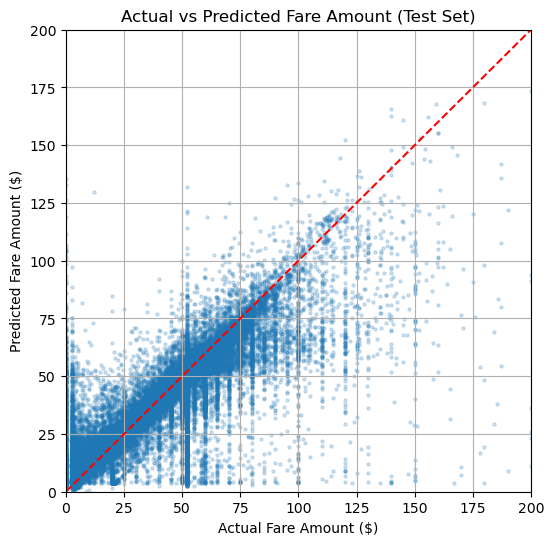

In [ ]:
## 시각화 
import matplotlib.pyplot as plt
import numpy as np

# --- test 예측값 수집 ---
best_model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(DEVICE)
        pred = best_model(xb).cpu().numpy().ravel()
        y_pred.append(pred)
        y_true.append(yb.numpy().ravel())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# --- scatter plot ---
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.2, s=5)
plt.plot([0, 200], [0, 200], 'r--')  # y=x 기준선
plt.xlabel("Actual Fare Amount ($)")
plt.ylabel("Predicted Fare Amount ($)")
plt.title("Actual vs Predicted Fare Amount (Test Set)")
plt.xlim(0, 200)
plt.ylim(0, 200)
plt.grid(True)
plt.show()
